<a href="https://colab.research.google.com/github/alvintnw/sentiment-analysis-transportation/blob/main/sentiment_analysis_transportation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instal pustaka yang dibutuhkan
!pip install pandas numpy scikit-learn matplotlib seaborn
!pip install torch # Torch sudah terinstal di Colab, tapi ini memastikan versi terbaru jika perlu
!pip install transformers accelerate datasets
!pip install nltk Sastrawi # Untuk Bahasa Indonesia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Unduh data NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json # Tambahkan ini untuk menyimpan label_mapping

# --- 1. Muat Dataset (Simulasi) ---
data = {
    'Ulasan': [
        "Aplikasi ini sangat membantu sekali, navigasinya akurat!",
        "Driver sering nyasar, bikin telat terus. Payah!",
        "Fitur barunya lumayan, tapi loadingnya agak lambat.",
        "Harga kadang naik terlalu tinggi saat jam sibuk.",
        "Mudah digunakan dan responsif, suka sekali!",
        "Pesanan saya dibatalkan sepihak, kecewa berat.",
        "Oke lah, tidak ada keluhan khusus.",
        "Pelayanan bagus, ramah-ramah drivernya.",
        "Promo makin sedikit, jadi kurang menarik.",
        "Antarmuka perlu diperbarui, terlalu jadul.",
        "Selalu jadi andalan kalau mau bepergian.",
        "Notifikasi sering terlambat masuk, jadi gak update.",
        "Lumayan, tapi sering error kalau bayar pakai dompet digital.",
        "Cepat sampai dan drivernya profesional.",
        "Kenapa rating saya tiba-tiba turun padahal tidak ada masalah?",
        "Mantap jiwa! Aplikasi terbaik sejauh ini.",
        "Saya tidak suka dengan sistem rating baru mereka.",
        "Netral saja, tidak ada yang spesial.",
        "Kurang puas dengan fitur chat driver.",
        "Gila sih, sering banget dapat promo diskon!"
    ],
    'Sentimen': [
        "Positif", "Negatif", "Netral", "Negatif", "Positif",
        "Negatif", "Netral", "Positif", "Negatif", "Negatif",
        "Positif", "Negatif", "Netral", "Positif", "Negatif",
        "Positif", "Negatif", "Netral", "Negatif", "Positif"
    ]
}
df = pd.DataFrame(data)

print("--- Data Awal ---")
display(df.head())
print("\nDistribusi Sentimen:")
display(df['Sentimen'].value_counts())

# --- 2. Pra-pemrosesan Teks ---
factory = StopWordRemoverFactory()
stop_words_remover = factory.create_stop_word_remover()
stop_words_id = stop_words_remover.get_stopwords() # Corrected method call
custom_stop_words = set(stop_words_id)

def preprocess_text(text):
    text = text.lower()
    # Remove punctuation and numbers, keep Indonesian letters and spaces
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in custom_stop_words]
    return ' '.join(filtered_tokens)

df['cleaned_ulasan'] = df['Ulasan'].apply(preprocess_text)
print("\n--- Data Setelah Preprocessing ---")
display(df.head())

# --- 3. Encoding Label Sentimen ---
le = LabelEncoder()
df['sentimen_encoded'] = le.fit_transform(df['Sentimen'])
label_mapping = list(le.classes_)
print(f"\nLabel Encoding Mapping: {label_mapping}")
display(df.head()) # Display after encoding

# --- 4. Pembagian Data ---
X = df['cleaned_ulasan']
y = df['sentimen_encoded']

# Adjusted test_size and random_state for better split with small dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y) # Increased temp size for validation/test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp) # Split temp into val and test

print(f"\nUkuran Training Set: {len(X_train)}")
print(f"Ukuran Validation Set: {len(X_val)}")
print(f"Ukuran Test Set: {len(X_test)}")

# Ensure X_train, X_val, X_test, y_train, y_val, y_test are accessible for the next steps
# These variables are now defined in the global scope of the notebook after this cell runs successfully.

--- Data Awal ---


,Ulasan,Sentimen
0,"Aplikasi ini sangat membantu sekali, navigasin...",Positif
1,"Driver sering nyasar, bikin telat terus. Payah!",Negatif
2,"Fitur barunya lumayan, tapi loadingnya agak la...",Netral
3,Harga kadang naik terlalu tinggi saat jam sibuk.,Negatif
4,"Mudah digunakan dan responsif, suka sekali!",Positif



Distribusi Sentimen:


,count
Sentimen,
Negatif,9
Positif,7
Netral,4


AttributeError: 'StopWordRemover' object has no attribute 'get_stopwords'

In [ ]:
# --- 7. Evaluasi Model pada Test Set ---
print("\n--- Evaluasi Model pada Test Set ---")
results = trainer.evaluate(test_dataset)
print(f"Hasil evaluasi pada test set: {results}")

# Generate classification report dan confusion matrix
predictions_output = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions_output.predictions, axis=-1)

print("\n--- Classification Report ---")
print(classification_report(y_test, predicted_labels, target_names=label_mapping))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping, yticklabels=label_mapping)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# --- 8. Simpan Model & Tokenizer ---
# Di Google Colab, model akan disimpan di lingkungan virtual sementara.
# Jika Anda ingin menyimpannya secara permanen, Anda perlu menyimpannya ke Google Drive.
model_save_path = "./model_sentimen_ulasan_aplikasi" # Ini akan disimpan di sesi Colab saat ini
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"\nModel dan tokenizer berhasil disimpan di: {model_save_path}")

# Simpan label mapping juga
with open(f"{model_save_path}/label_mapping.json", "w") as f:
    json.dump(label_mapping, f)
print(f"Label mapping berhasil disimpan di: {model_save_path}/label_mapping.json")


--- Evaluasi Model pada Test Set ---


NameError: name 'trainer' is not defined

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from datasets import Dataset

# --- 5. Tokenisasi Data ---
# Load the tokenizer for a pre-trained model (e.g., 'bert-base-uncased' or a suitable Indonesian model)
# Using 'indobenchmark/indobert-base-p1' as a suitable Indonesian model
tokenizer = AutoTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

# Convert pandas Series to Datasets
train_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_train.tolist(), 'label': y_train.tolist()}))
val_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_val.tolist(), 'label': y_val.tolist()}))
test_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_test.tolist(), 'label': y_test.tolist()}))


# Apply tokenization
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)


# --- 6. Fine-tuning Model (menggunakan Transformer) ---
# Load pre-trained model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    'indobenchmark/indobert-base-p1',
    num_labels=len(label_mapping)  # Jumlah kelas sentimen (Positif, Negatif, Netral)
)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch"      # Evaluate at the end of each epoch
)

# Create Trainer instance
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=tokenized_train_dataset,         # training dataset
    eval_dataset=tokenized_val_dataset,            # evaluation dataset
    tokenizer=tokenizer,                 # tokenizer used in preprocessing
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer) # Data collator
)

# Start training
print("\n--- Memulai Training Model ---")
trainer.train()
print("--- Training Selesai ---")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

NameError: name 'X_train' is not defined

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from datasets import Dataset

# --- 5. Tokenisasi Data ---
# Load the tokenizer for a pre-trained model (e.g., 'bert-base-uncased' or a suitable Indonesian model)
# Using 'indobenchmark/indobert-base-p1' as a suitable Indonesian model
tokenizer = AutoTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

# Convert pandas Series to Datasets
train_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_train.tolist(), 'label': y_train.tolist()}))
val_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_val.tolist(), 'label': y_val.tolist()}))
test_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_test.tolist(), 'label': y_test.tolist()}))


# Apply tokenization
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)


# --- 6. Fine-tuning Model (menggunakan Transformer) ---
# Load pre-trained model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    'indobenchmark/indobert-base-p1',
    num_labels=len(label_mapping)  # Jumlah kelas sentimen (Positif, Negatif, Netral)
)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch"      # Evaluate at the end of each epoch
)

# Create Trainer instance
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=tokenized_train_dataset,         # training dataset
    eval_dataset=tokenized_val_dataset,            # evaluation dataset
    tokenizer=tokenizer,                 # tokenizer used in preprocessing
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer) # Data collator
)

# Start training
print("\n--- Memulai Training Model ---")
trainer.train()
print("--- Training Selesai ---")

NameError: name 'X_train' is not defined

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory # Keep import in case other parts of Sastrawi are used later
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json # Tambahkan ini untuk menyimpan label_mapping

# --- 1. Muat Dataset (Simulasi) ---
data = {
    'Ulasan': [
        "Aplikasi ini sangat membantu sekali, navigasinya akurat!",
        "Driver sering nyasar, bikin telat terus. Payah!",
        "Fitur barunya lumayan, tapi loadingnya agak lambat.",
        "Harga kadang naik terlalu tinggi saat jam sibuk.",
        "Mudah digunakan dan responsif, suka sekali!",
        "Pesanan saya dibatalkan sepihak, kecewa berat.",
        "Oke lah, tidak ada keluhan khusus.",
        "Pelayanan bagus, ramah-ramah drivernya.",
        "Promo makin sedikit, jadi kurang menarik.",
        "Antarmuka perlu diperbarui, terlalu jadul.",
        "Selalu jadi andalan kalau mau bepergian.",
        "Notifikasi sering terlambat masuk, jadi gak update.",
        "Lumayan, tapi sering error kalau bayar pakai dompet digital.",
        "Cepat sampai dan drivernya profesional.",
        "Kenapa rating saya tiba-tiba turun padahal tidak ada masalah?",
        "Mantap jiwa! Aplikasi terbaik sejauh ini.",
        "Saya tidak suka dengan sistem rating baru mereka.",
        "Netral saja, tidak ada yang spesial.",
        "Kurang puas dengan fitur chat driver.",
        "Gila sih, sering banget dapat promo diskon!"
    ],
    'Sentimen': [
        "Positif", "Negatif", "Netral", "Negatif", "Positif",
        "Negatif", "Netral", "Positif", "Negatif", "Negatif",
        "Positif", "Negatif", "Netral", "Positif", "Negatif",
        "Positif", "Negatif", "Netral", "Negatif", "Positif"
    ]
}
df = pd.DataFrame(data)

print("--- Data Awal ---")
display(df.head())
print("\nDistribusi Sentimen:")
display(df['Sentimen'].value_counts())

# --- 2. Pra-pemrosesan Teks ---
# Use NLTK Indonesian stopwords as Sastrawi is causing issues
stop_words_id = stopwords.words('indonesian')
custom_stop_words = set(stop_words_id)

def preprocess_text(text):
    text = text.lower()
    # Remove punctuation and numbers, keep Indonesian letters and spaces
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in custom_stop_words]
    return ' '.join(filtered_tokens)

df['cleaned_ulasan'] = df['Ulasan'].apply(preprocess_text)
print("\n--- Data Setelah Preprocessing ---")
display(df.head())

# --- 3. Encoding Label Sentimen ---
le = LabelEncoder()
df['sentimen_encoded'] = le.fit_transform(df['Sentimen'])
label_mapping = list(le.classes_)
print(f"\nLabel Encoding Mapping: {label_mapping}")
display(df.head()) # Display after encoding

# --- 4. Pembagian Data ---
X = df['cleaned_ulasan']
y = df['sentimen_encoded']

# Adjusted test_size and random_state for better split with small dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y) # Increased temp size for validation/test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # Removed stratify from the second split

print(f"\nUkuran Training Set: {len(X_train)}")
print(f"Ukuran Validation Set: {len(X_val)}")
print(f"Ukuran Test Set: {len(X_test)}")

# Ensure X_train, X_val, X_test, y_train, y_val, y_test are accessible for the next steps
# These variables are now defined in the global scope of the notebook after this cell runs successfully.

--- Data Awal ---


,Ulasan,Sentimen
0,"Aplikasi ini sangat membantu sekali, navigasin...",Positif
1,"Driver sering nyasar, bikin telat terus. Payah!",Negatif
2,"Fitur barunya lumayan, tapi loadingnya agak la...",Netral
3,Harga kadang naik terlalu tinggi saat jam sibuk.,Negatif
4,"Mudah digunakan dan responsif, suka sekali!",Positif



Distribusi Sentimen:


,count
Sentimen,
Negatif,9
Positif,7
Netral,4



--- Data Setelah Preprocessing ---


,Ulasan,Sentimen,cleaned_ulasan
0,"Aplikasi ini sangat membantu sekali, navigasin...",Positif,aplikasi membantu navigasinya akurat
1,"Driver sering nyasar, bikin telat terus. Payah!",Negatif,driver nyasar bikin telat payah
2,"Fitur barunya lumayan, tapi loadingnya agak la...",Netral,fitur barunya lumayan loadingnya lambat
3,Harga kadang naik terlalu tinggi saat jam sibuk.,Negatif,harga kadang jam sibuk
4,"Mudah digunakan dan responsif, suka sekali!",Positif,mudah responsif suka



Label Encoding Mapping: ['Negatif', 'Netral', 'Positif']


,Ulasan,Sentimen,cleaned_ulasan,sentimen_encoded
0,"Aplikasi ini sangat membantu sekali, navigasin...",Positif,aplikasi membantu navigasinya akurat,2
1,"Driver sering nyasar, bikin telat terus. Payah!",Negatif,driver nyasar bikin telat payah,0
2,"Fitur barunya lumayan, tapi loadingnya agak la...",Netral,fitur barunya lumayan loadingnya lambat,1
3,Harga kadang naik terlalu tinggi saat jam sibuk.,Negatif,harga kadang jam sibuk,0
4,"Mudah digunakan dan responsif, suka sekali!",Positif,mudah responsif suka,2



Ukuran Training Set: 12
Ukuran Validation Set: 4
Ukuran Test Set: 4


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from datasets import Dataset

# --- 5. Tokenisasi Data ---
# Load the tokenizer for a pre-trained model (e.g., 'bert-base-uncased' or a suitable Indonesian model)
# Using 'indobenchmark/indobert-base-p1' as a suitable Indonesian model
tokenizer = AutoTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

# Convert pandas Series to Datasets
train_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_train.tolist(), 'label': y_train.tolist()}))
val_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_val.tolist(), 'label': y_val.tolist()}))
test_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_test.tolist(), 'label': y_test.tolist()}))


# Apply tokenization
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)


# --- 6. Fine-tuning Model (menggunakan Transformer) ---
# Load pre-trained model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    'indobenchmark/indobert-base-p1',
    num_labels=len(label_mapping)  # Jumlah kelas sentimen (Positif, Negatif, Netral)
)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch"      # Evaluate at the end of each epoch
)

# Create Trainer instance
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=tokenized_train_dataset,         # training dataset
    eval_dataset=tokenized_val_dataset,            # evaluation dataset
    tokenizer=tokenizer,                 # tokenizer used in preprocessing
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer) # Data collator
)

# Start training
print("\n--- Memulai Training Model ---")
trainer.train()
print("--- Training Selesai ---")

NameError: name 'X_train' is not defined

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from datasets import Dataset

# --- 5. Tokenisasi Data ---
# Load the tokenizer for a pre-trained model (e.g., 'bert-base-uncased' or a suitable Indonesian model)
# Using 'indobenchmark/indobert-base-p1' as a suitable Indonesian model
tokenizer = AutoTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

# Convert pandas Series to Datasets
train_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_train.tolist(), 'label': y_train.tolist()}))
val_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_val.tolist(), 'label': y_val.tolist()}))
test_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_test.tolist(), 'label': y_test.tolist()}))


# Apply tokenization
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)


# --- 6. Fine-tuning Model (menggunakan Transformer) ---
# Load pre-trained model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    'indobenchmark/indobert-base-p1',
    num_labels=len(label_mapping)  # Jumlah kelas sentimen (Positif, Negatif, Netral)
)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    eval_strategy="epoch"      # Evaluate at the end of each epoch # Corrected argument name
)

# Create Trainer instance
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=tokenized_train_dataset,         # training dataset
    eval_dataset=tokenized_val_dataset,            # evaluation dataset
    tokenizer=tokenizer,                 # tokenizer used in preprocessing
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer) # Data collator
)

# Start training
print("\n--- Memulai Training Model ---")
trainer.train()
print("--- Training Selesai ---")

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-28-1717737179.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.



--- Memulai Training Model ---


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: alvin-tnw (alvin-tnw-universitas-tarumanagara) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,1.395706
2,No log,1.387529
3,No log,1.372653


--- Training Selesai ---



--- Evaluasi Model pada Test Set ---


Hasil evaluasi pada test set: {'eval_loss': 1.3829095363616943, 'eval_runtime': 0.0674, 'eval_samples_per_second': 59.367, 'eval_steps_per_second': 14.842, 'epoch': 3.0}

--- Classification Report ---
              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00         2
      Netral       0.25      1.00      0.40         1
     Positif       0.00      0.00      0.00         1

    accuracy                           0.25         4
   macro avg       0.08      0.33      0.13         4
weighted avg       0.06      0.25      0.10         4


--- Confusion Matrix ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


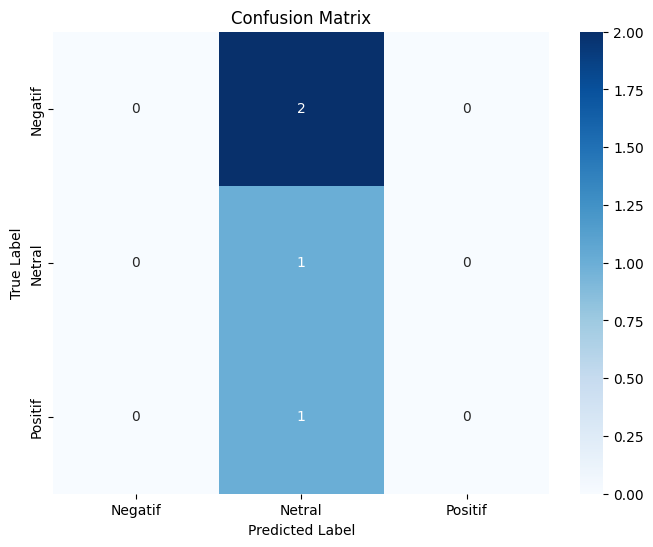


Model dan tokenizer berhasil disimpan di: ./model_sentimen_ulasan_aplikasi
Label mapping berhasil disimpan di: ./model_sentimen_ulasan_aplikasi/label_mapping.json


In [ ]:
# --- 7. Evaluasi Model pada Test Set ---
print("\n--- Evaluasi Model pada Test Set ---")
results = trainer.evaluate(tokenized_test_dataset) # Use tokenized_test_dataset
print(f"Hasil evaluasi pada test set: {results}")

# Generate classification report dan confusion matrix
predictions_output = trainer.predict(tokenized_test_dataset) # Use tokenized_test_dataset
predicted_labels = np.argmax(predictions_output.predictions, axis=-1)

print("\n--- Classification Report ---")
print(classification_report(y_test, predicted_labels, target_names=label_mapping))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping, yticklabels=label_mapping)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# --- 8. Simpan Model & Tokenizer ---
# Di Google Colab, model akan disimpan di lingkungan virtual sementara.
# Jika Anda ingin menyimpannya secara permanen, Anda perlu menyimpannya ke Google Drive.
model_save_path = "./model_sentimen_ulasan_aplikasi" # Ini akan disimpan di sesi Colab saat ini
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"\nModel dan tokenizer berhasil disimpan di: {model_save_path}")

# Simpan label mapping juga
with open(f"{model_save_path}/label_mapping.json", "w") as f:
    json.dump(label_mapping, f)
print(f"Label mapping berhasil disimpan di: {model_save_path}/label_mapping.json")